In this notebook, we compare the data-scaling of different learning algorithms on SVHN.

The methods we compare are:
1. Random guessing
2. Training a DNN from scratch. (Bahri et al., Rosenfeld et al.)
3. Linear probe on top of a pretrained model. (CLIP, LAION CLIP)
4. Finetuning a pretrained model.

### Load libraries

In [1]:
import os
import pathlib
import sys
from typing import Any, Optional, Type

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10
from src.pretrain.models import BaseEmbedderConfig, get_embedder_index

transformers.logging.set_verbosity_error()

### Load wandb data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={
        "$and": [
            {"tags": {"$in": ["probe-seeds-v1"]}},
            {"config.dataset_cfg.id": {"$eq": "svhn"}},
        ]
    },
)
len(runs)

450

In [3]:
def get_df_from_run(
    # run: wandb.apis.public.Run,
    run_id: str,
    run_config: dict[str, Any],
    run_summary: dict[str, Any],
    # run_summary: dict[str, Any],
) -> pd.DataFrame:
    api = wandb.Api(timeout=30)
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run_id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run_config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run_config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run_summary["embed_dim"]
    ret_df["n_embedder_params"] = run_summary["n_embedder_params"]
    ret_df["seed"] = run_config["seed"]

    for i in range(10):
        ret_df[f"err_{i}"] = 1 - ret_df[f"acc_{i}"]

    return ret_df


dfs = process_map(
    get_df_from_run,
    [r.id for r in runs],
    [dict(r.config) for r in runs],
    [
        {k: r.summary[k] for k in ("embed_dim", "n_embedder_params")}
        for r in runs
    ],
    max_workers=15,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
)
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

100%|██████████| 450/450 [00:26<00:00, 16.75it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,err_2,err_3,err_4,err_5,err_6,err_7,err_8,err_9,model,model_type
0,0.01,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
1,1.00,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
2,100.00,10000.0,49,True,0.159381,inf,1,False,linear,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,openai/ViT-B/16,openai/Vi
3,NaN,NaN,49,True,0.088238,NaN,2,False,knn,0,...,1.000000,0.583969,1.000000,1.000000,1.000000,1.000000,1.000000,0.311599,openai/ViT-B/16,openai/Vi
4,0.01,10000.0,49,True,0.088238,inf,2,False,linear,0,...,1.000000,0.583969,1.000000,1.000000,1.000000,1.000000,1.000000,0.311599,openai/ViT-B/16,openai/Vi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198445,NaN,NaN,1,True,0.582667,NaN,4659,True,knn,0,...,0.260304,0.461138,0.509314,0.403104,0.491654,0.411590,0.500000,0.507837,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
198446,NaN,NaN,1,True,0.630570,NaN,4659,True,knn,0,...,0.240781,0.438931,0.396354,0.328859,0.410218,0.316493,0.412048,0.436364,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
198447,0.01,10000.0,1,True,0.818915,0.569211,4659,True,linear,0,...,0.150639,0.284178,0.142687,0.184564,0.201821,0.130758,0.222289,0.167398,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP
198448,1.00,10000.0,1,True,0.791718,0.707099,4659,True,linear,0,...,0.176428,0.301527,0.187475,0.218121,0.221042,0.154532,0.244578,0.197492,hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K,hf/laion/CLIP


### Finetuning data

In [4]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/finetune",
    filters={"tags": {"$in": ["svhn-finetune-v1"]}},
)

df_finetune = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_finetune["test_err"] = 1 - df_finetune.test_acc
df_finetune["val_err"] = 1 - df_finetune.val_acc_max
df_finetune["train_err"] = 1 - df_finetune.train_acc_max
print(len(df_finetune))
df_finetune.tail()

33


,test_acc,init_test_loss,_wandb_runtime,val_acc_max,init_test_imgs_height,init_test_imgs_width,init_test_imgs__type,init_test_imgs_captions,init_test_imgs_count,init_test_imgs_filenames,...,lr_decay_patience_evals,log_imgs_during_training,init_with_trained_linear_probe,id,run_path,name,state,test_err,val_err,train_err
28,0.975914,2.359918,7780.0,0.9701,224.0,224.0,images/separated,"[pred='4'; lab='5', pred='4'; lab='2', pred='4...",15.0,[media/images/init_test_imgs_0_65b9d9bf8ed212f...,...,5,False,False,3mmqbs95,data-frugal-learning/finetune/3mmqbs95,woven-night-750,finished,0.024086,0.0299,0.0
29,0.965888,2.309062,1405.0,0.9604,224.0,224.0,images/separated,"[pred='7'; lab='5', pred='7'; lab='2', pred='7...",15.0,[media/images/init_test_imgs_0_65b9d9bf8ed212f...,...,5,False,False,33my9vd6,data-frugal-learning/finetune/33my9vd6,good-firefly-777,finished,0.034112,0.0396,0.0
30,0.970267,2.309062,1143.0,0.9613,224.0,224.0,images/separated,"[pred='7'; lab='5', pred='7'; lab='2', pred='7...",15.0,[media/images/init_test_imgs_0_65b9d9bf8ed212f...,...,5,False,False,3ul5nyld,data-frugal-learning/finetune/3ul5nyld,deft-blaze-752,finished,0.029733,0.0387,0.0
31,0.976298,2.268797,4639.0,0.9675,224.0,224.0,images/separated,"[pred='1'; lab='5', pred='1'; lab='2', pred='1...",15.0,[media/images/init_test_imgs_0_65b9d9bf8ed212f...,...,5,False,False,37rtfar9,data-frugal-learning/finetune/37rtfar9,drawn-plant-765,finished,0.023702,0.0325,0.0
32,0.979525,2.359918,12967.0,0.9715,224.0,224.0,images/separated,"[pred='4'; lab='5', pred='4'; lab='2', pred='4...",15.0,[media/images/init_test_imgs_0_65b9d9bf8ed212f...,...,5,False,False,14kwbwf4,data-frugal-learning/finetune/14kwbwf4,stellar-water-745,finished,0.020475,0.0285,0.0


In [5]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/finetune",
    filters={"tags": {"$in": ["probe-scaling-svhn-v1"]}},
)

df_probe_scaling = (
    utils.runs_to_df(runs)
    .query("state == 'finished'")
    .sort_values(
        "n_train"
    ).reset_index(drop=True)
)
df_probe_scaling["test_err"] = 1 - df_probe_scaling.test_acc
df_probe_scaling["val_err"] = 1 - df_probe_scaling.val_acc_max
df_probe_scaling["train_err"] = 1 - df_probe_scaling.train_acc_max
print(len(df_probe_scaling))
df_probe_scaling.tail()

33


,_runtime,test_loss,n_trainable_params,best_checkpoint_steps,val_acc_max,val_loss_min,step,test_acc,train_loss_min,n_total_params,...,lr_decay_patience_evals,log_imgs_during_training,init_with_trained_linear_probe,id,run_path,name,state,test_err,val_err,train_err
28,7867.083654,0.824103,267786,67000,0.6871,0.952107,67001,0.733751,0.399624,86460426,...,5,False,False,3euh7hxw,data-frugal-learning/finetune/3euh7hxw,denim-fire-964,finished,0.266249,0.3129,0.04
29,5381.853806,0.780422,530442,44500,0.7020,0.903123,44501,0.744199,0.313832,86723082,...,5,False,False,2tpuqksc,data-frugal-learning/finetune/2tpuqksc,whole-eon-968,finished,0.255801,0.2980,0.04
30,4879.772007,0.834967,267786,38000,0.6861,0.964026,40501,0.730870,0.364550,86460426,...,5,False,False,34t4jlhm,data-frugal-learning/finetune/34t4jlhm,peach-flower-971,finished,0.269130,0.3139,0.00
31,5194.200878,0.778741,530442,42000,0.7015,0.898501,44501,0.744891,0.227911,86723082,...,5,False,False,3oe0zhea,data-frugal-learning/finetune/3oe0zhea,chocolate-dew-972,finished,0.255109,0.2985,0.00
32,5673.422639,0.763875,793098,48500,0.7072,0.885345,51501,0.749962,0.072534,86985738,...,5,False,False,37u6mxw8,data-frugal-learning/finetune/37u6mxw8,iconic-water-974,finished,0.250038,0.2928,0.00


### Load transcribed data from papers

In [6]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-2021/svhn/wpd-clean.csv")

df_prune = (
    pd.read_csv(GIT_ROOT / "data/sorscher-2022/svhn/wpd-clean.csv")
    .sort_values("n_train")
    .reset_index(drop=True)
)
df_prune["err"] = df_prune.res_err + df_prune.bayes_err
df_prune.tail()

,n_train,res_err,bayes_err,err
20,64821.174005,0.010849,0.011,0.021849
21,109685.672147,0.008840,0.011,0.019840
22,179770.348611,0.009754,0.011,0.020754
23,298852.992713,0.008953,0.011,0.019953
24,498088.179075,0.009303,0.011,0.020303


### Generate plots

In [31]:
def plot_wandb_df(
    df: pd.DataFrame,
    query: str,
    target: str = "err",
    ci: float = 0.99,
    **kwargs,
):
    gb = df.query(
        "&".join(
            (
                "dataset_id == 'svhn'",
                "cls_start == 0",
                "cls_end == 10",
                "(c == 100 | k == 1)",
                # "embedder_id == 'openai/ViT-L/14'",
                # "probe == 'linear'",
                # "per_class == False",
                query,
            )
        )
    ).groupby(["n_train"])

    ax = gb[target].median().plot(**kwargs)
    prev_color = ax.lines[-1].get_color()
    plt.fill_between(
        gb[target].median().index,
        gb[target].quantile(0.5 - ci / 2),
        gb[target].quantile(0.5 + ci / 2),
        alpha=0.2,
        color=prev_color,
        edgecolor="none",
        zorder=ax.lines[-1].get_zorder() - 1,
    )
    return ax

def plot_strong_baselines():
    # http://ufldl.stanford.edu/housenumbers/nips2011_housenumbers.pdf
    plt.axhline(
        2 / 100,
        color="k",
        linestyle=":",
        label="Human performance (98%)",
        zorder=-10,
        alpha=0.5,
    )

    # https://paperswithcode.com/sota/image-classification-on-svhn
    plt.axhline(
        0.99 / 100,
        color="k",
        linestyle="--",
        label="SOTA (paperswithcode.com 2022-12-30)",
        zorder=-10,
    )

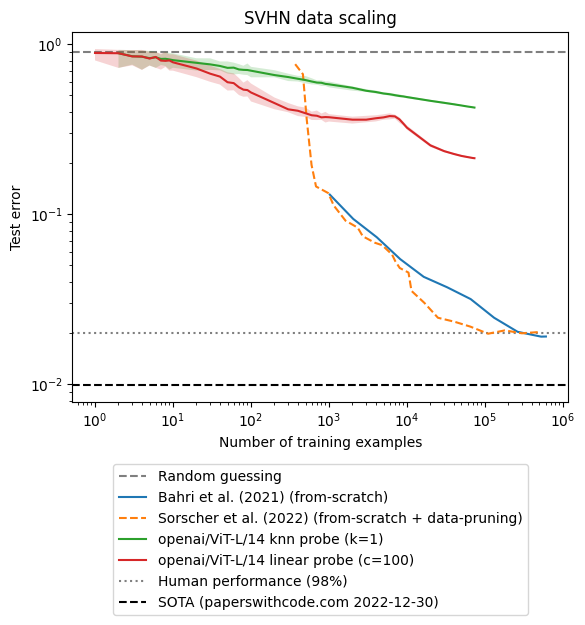

In [32]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
plt.plot(
    df_prune.n_train,
    df_prune.err,
    label="Sorscher et al. (2022) (from-scratch + data-pruning)",
    linestyle="--",
)
# plt.plot(
#     df_prune_transfer.n_train,
#     df_prune_transfer.err,
#     label="Sorscher et al. (2022) (data pruning + whole-model-finetuning)",
# )
# plt.plot(
#     df_prune_scratch.n_train,
#     df_prune_scratch.err,
#     label="Pruning paper (from scratch)",
# )

for embedder_id in (
    "openai/ViT-L/14",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
        label=f"{embedder_id} knn probe (k=1)",
    )
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )

plot_strong_baselines()
plt.title(f"SVHN data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

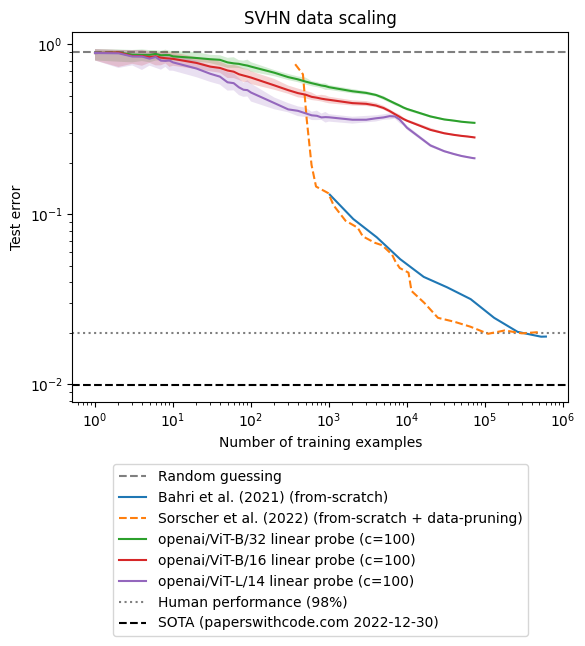

In [33]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
plt.plot(
    df_prune.n_train,
    df_prune.err,
    label="Sorscher et al. (2022) (from-scratch + data-pruning)",
    linestyle="--",
)

for embedder_id in (
    "openai/ViT-B/32",
    "openai/ViT-B/16",
    "openai/ViT-L/14",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )

plot_strong_baselines()
plt.title(f"SVHN data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

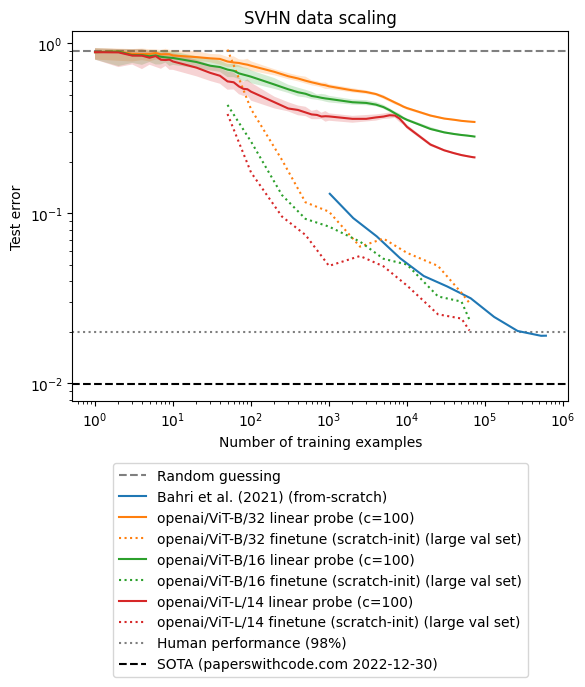

In [34]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)
# plt.plot(
#     df_prune.n_train,
#     df_prune.err,
#     label="Sorscher et al. (2022) (from-scratch + data-pruning)",
#     linestyle="--",
# )

for embedder_id in (
    "openai/ViT-B/32",
    "openai/ViT-B/16",
    "openai/ViT-L/14",
    # "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    # "hf/microsoft/beit-large-patch16-224",
):
    ax = plot_wandb_df(
        df,
        query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
        label=f"{embedder_id} linear probe (c=100)",
    )
    prev_color = ax.lines[-1].get_color()

    cdf = df_finetune.query(
        "&".join(
            (
                "embedder_cfg_id == @embedder_id",
                "~init_with_trained_linear_probe",
            )
        )
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train - cdf.n_val_override,
        cdf.test_err,
        linestyle=":",
        color=prev_color,
        label=f"{embedder_id} finetune (scratch-init) (large val set)",
    )

plot_strong_baselines()
plt.title(f"SVHN data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

### Study different types of probes

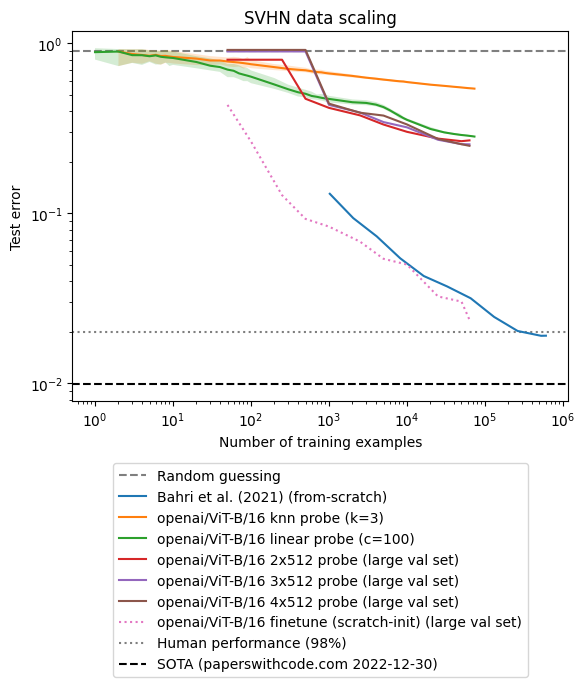

In [35]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)"
)

embedder_id = "openai/ViT-B/16"

plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'knn' & per_class == False",
    label=f"{embedder_id} knn probe (k=3)",
)
plot_wandb_df(
    df,
    query=f"embedder_id == '{embedder_id}' & probe == 'linear' & per_class == False",
    label=f"{embedder_id} linear probe (c=100)",
)

for n_layers in [2, 3, 4]:
    for hidden_dim in [512]:  # [512, 1024, 2048]:
        cdf = (
            df_probe_scaling.query(
                "&".join(
                    (
                        f"embedder_cfg_id == @embedder_id",
                        f"fc_probe_cfg_n_layers == @n_layers",
                        f"fc_probe_cfg_hidden_dim == @hidden_dim",
                    )
                )
            )
            .sort_values("n_train")
            .reset_index(drop=True)
        )
        ax = plt.plot(
            cdf.n_train - cdf.n_val_override,
            cdf.test_err,
            label=f"{embedder_id} {n_layers}x{hidden_dim} probe (large val set)",
        )

cdf = df_finetune.query(
    "&".join(
        (
            "embedder_cfg_id == @embedder_id",
            "~init_with_trained_linear_probe",
        )
    )
).sort_values("n_train")
plt.plot(
    cdf.n_train - cdf.n_val_override,
    cdf.test_err,
    linestyle=":",
    label=f"{embedder_id} finetune (scratch-init) (large val set)",
)

plot_strong_baselines()
plt.title(f"SVHN data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
)
plt.show()

Not sure why we get a weird kink for the large probes above.
It seems to be a result of test and val error having a big gap...
Why does this happen in the small data regime for SVHN?